In [1]:
'__authour__ == Kanaan'

%matplotlib inline
import os,sys
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, TSNE, LocallyLinearEmbedding, MDS, SpectralEmbedding
import scipy.stats as ss
import sklearn.metrics as sm
from scipy.cluster.hierarchy import inconsistent, linkage, dendrogram

sys.path.append('./')
from utils import change_width, normalize_df_bycol, get_season
from preprocess import preproc_iphone_data, df_group_timefeature
from plotting import plt_world_map, plot_bar, plot_reg, cmap_gradient 
from cluster import plot_dendogram, plot_elbow, return_cluster_dfs
from decompose import plot_cluster_components

# set some viz options
pd.options.display.max_columns=100
sns.set_style('whitegrid')

import vincent
vincent.core.initialize_notebook()
vincent.initialize_notebook()
dpi = 300

winter


/Users/kanaan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<center> <img src="./FIGS/device.png" alt="Drawing"> <center>

<center> <h1> Precision Running Project </h1> </center>
<center> <h3> Ahmad Seif Kanaan PhD </h3> </center>


#  Features
- Nike+RunClub: Distance (km)
- Nike+RunClub: Average Speed(m/s) & Tempo (min/km)
- Nike+RunClub: Calories Burnt(kcal)
- AppleHealthKit: Mass (kg)
- AppleHealthKit: Walking+Running (km)
- AppleHealthKit: Elevation Gain (m)
- AppleHealthKit: Steps (count)

# Objectives
- Track Marathon training progress 
- Inspect improvement in total running distance and pace
- Inpsect relationship between RunDistance, RunSpeed, ElevationGain and time (month,week,day,hour) features 
- Inpsect relationship between Running and Health Features  
- Inspect whether H-Clustering can categorize days into sendetary, short-distance, long-distance and elevation days


# Parse Sensor xml files 

In [2]:
# for extraction tools see https://github.com/amadeuskanaan/PrecisionRunning/blob/master/extract.py

# Import RAW CSVs

In [3]:
# import data 
nike_run = pd.read_csv('Data/NikeRunClub.csv', index_col = 0)
apple_WalkRun = pd.read_csv('Data/DistanceWalkingRunning.csv')
apple_BodyMass = pd.read_csv('Data/BodyMass.csv')
apple_BodyFat = pd.read_csv('Data/BodyFatPercentage.csv')
apple_steps = pd.read_csv('Data/StepCount.csv')
apple_sleep = pd.read_csv('Data/SleepAnalysis.csv')
apple_climb = pd.read_csv('Data/FlightsClimbed.csv')

# Preproces Nike+RunClub and AppleHealthKit CSVs

In [4]:
# for preprocessing tools see https://github.com/amadeuskanaan/PrecisionRunning/blob/master/preprocess.py
nike_run       = preproc_iphone_data(nike_run, 'Nike')
apple_walkrun  = preproc_iphone_data(apple_WalkRun, 'Apple')
apple_mass     = preproc_iphone_data(apple_BodyMass, 'Apple')
apple_elev     = preproc_iphone_data(apple_climb, 'Apple')
apple_steps    = preproc_iphone_data(apple_steps, 'Apple')

In [5]:
# Sum nike dataframe by Hour
nike_run_sum_hour = df_group_timefeature(nike_run, 'Time_of_day', 'sum')

# Sum nike df by weekday
weekdays=['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday', 'Sunday']
nike_run_sum_week = df_group_timefeature(nike_run, 'Weekday', 'sum')
nike_run_sum_week = nike_run_sum_week.reindex(weekdays)

# Sum nike df by season
nike_run_sum_season = df_group_timefeature(nike_run, 'Season', 'sum')

# count nike df by weekday
nike_run_count_week = df_group_timefeature(nike_run, 'Weekday', 'count')
nike_run_count_week = nike_run_count_week.reindex(weekdays)

# Trails

/Users/kanaan/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/kanaan/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/kanaan/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


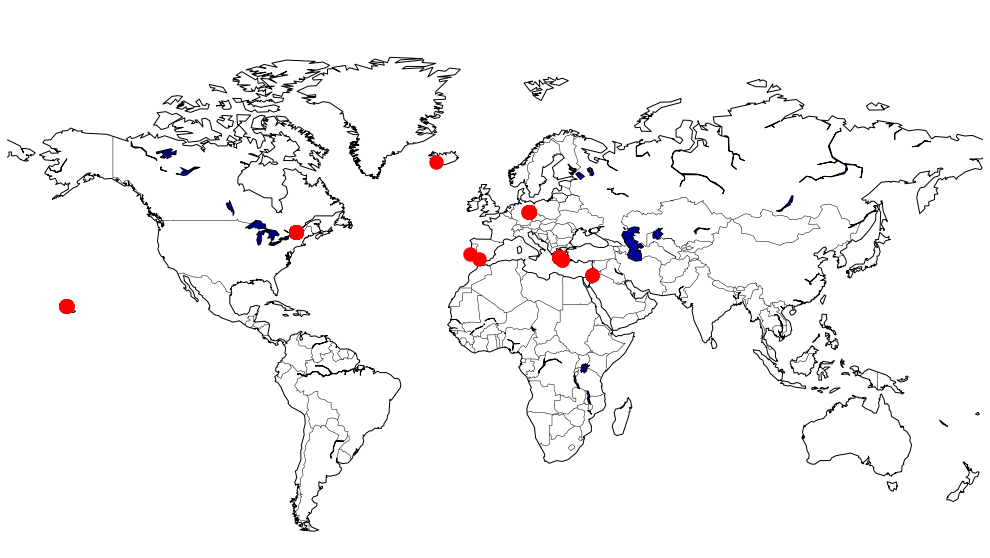

In [6]:
plt_world_map(nike_run, title =None, fname='./FIGS/world_map.png')

# Running Distance

In [7]:
def plot_bar(df, feature, palette, title, xlabel, ylabel, labelsize=20, rot=70):
    fig, ax = plt.subplots(figsize=(20,12))
    g = sns.barplot(df.index, df[feature],palette= palette)
    sns.despine(top=True,right=True)
    plt.xticks(rotation=rot, fontsize=labelsize,weight='bold')
    plt.yticks(fontsize=15, weight='bold')
    plt.title(title, fontsize=55, weight='bold')
    plt.xlabel(xlabel, fontsize=35, labelpad=15, weight='bold')
    plt.ylabel(ylabel, fontsize=35, weight='bold')
    change_width(ax, 0.98)
    return fig, ax, g


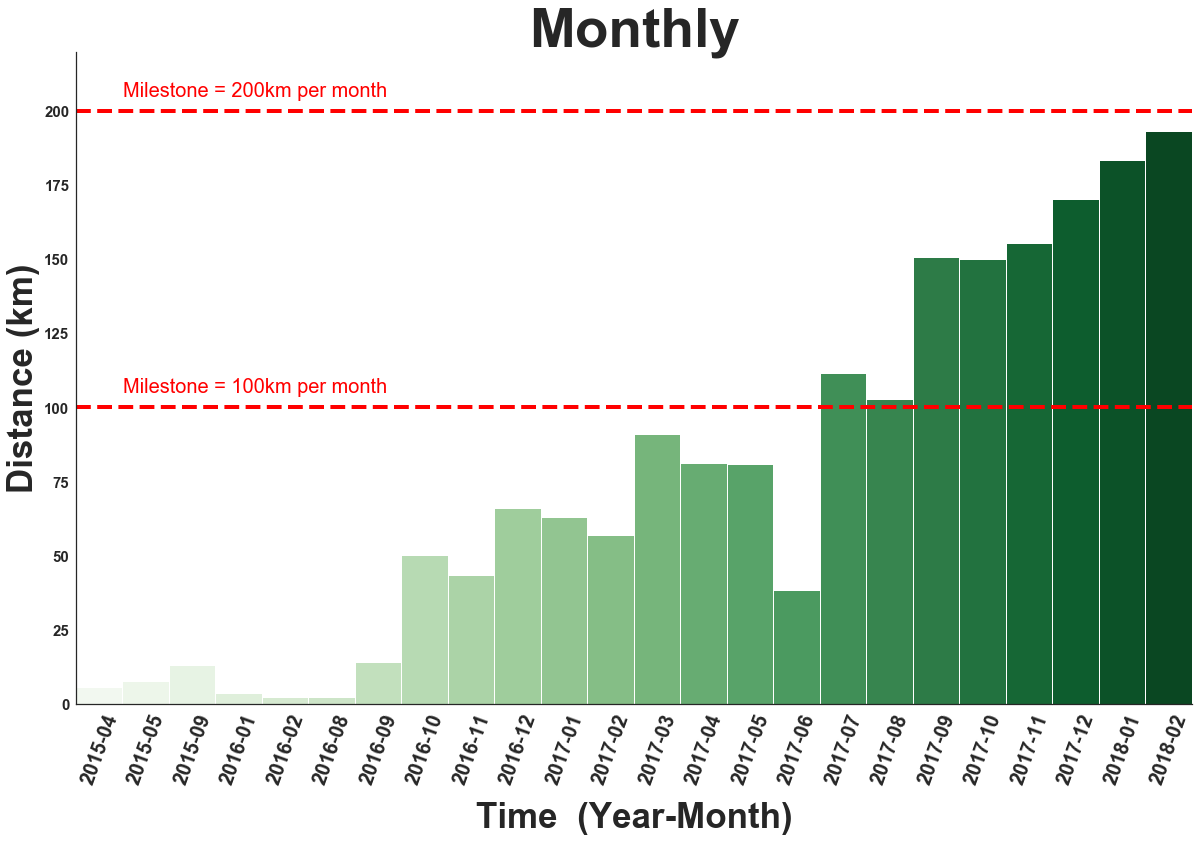

In [8]:
# Sum nike dataframe by Month
sns.set_style('white')
nike_run_sum_month = df_group_timefeature(nike_run, 'Month', 'sum')

# Drop years before 2015
years = ['2015','2016','2017','2018']
nike_run_sum_month = nike_run_sum_month.drop([i for i in nike_run_sum_month.index if i[0:4] not in years])

sns.set_style('white')
# Plot
fig, ax, g = plot_bar(df      =  nike_run_sum_month, feature = 'Distance', palette = 'Greens',
                      #title   = 'Nike+RunClub - Total Running Distance - Monthly', 
                      title   = 'Monthly', 
                      xlabel  = 'Time  (Year-Month)', ylabel  = 'Distance (km)')
plt.ylim(0,220)
plt.axhline(100,color='r', linewidth=4, linestyle='--')
plt.axhline(200,color='r', linewidth=4, linestyle='--')
plt.annotate('Milestone = 200km per month', xy=(.5, 205), fontsize=20,color='red')
plt.annotate('Milestone = 100km per month', xy=(.5, 105), fontsize=20,color='red')
fig.savefig('FIGS/run_dist_month.png',bbox_inches='tight',dpi=dpi)

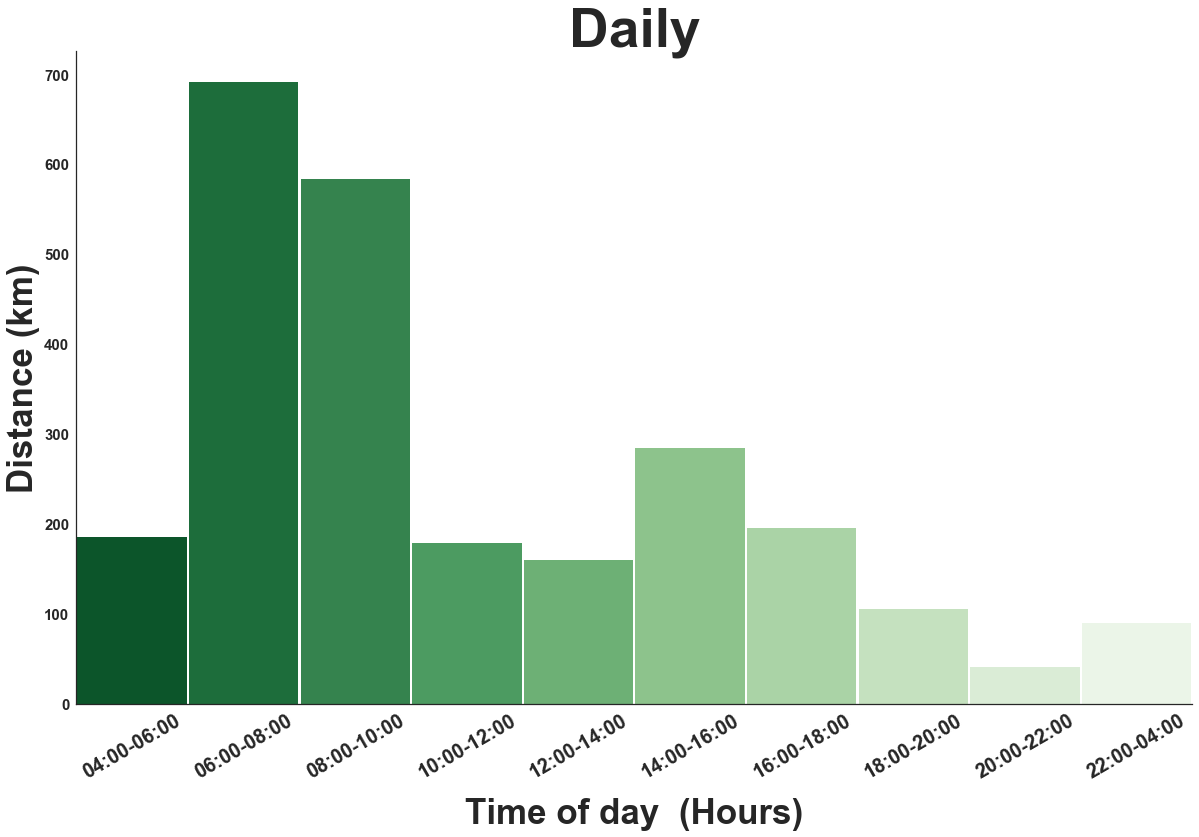

In [9]:

fig, ax, g = plot_bar(df      =  nike_run_sum_hour, 
                      feature = 'Distance', 
                      palette = 'Greens_r',
                      #title   = 'Nike+RunClub -Total Running Distance - Daily \n', 
                      title   = 'Daily', 
                      ylabel  = 'Distance (km)',
                      xlabel  = 'Time of day  (Hours)', 
                      rot = 30)
fig.savefig('FIGS/run_dist_daily.png',bbox_inches='tight',dpi=dpi)

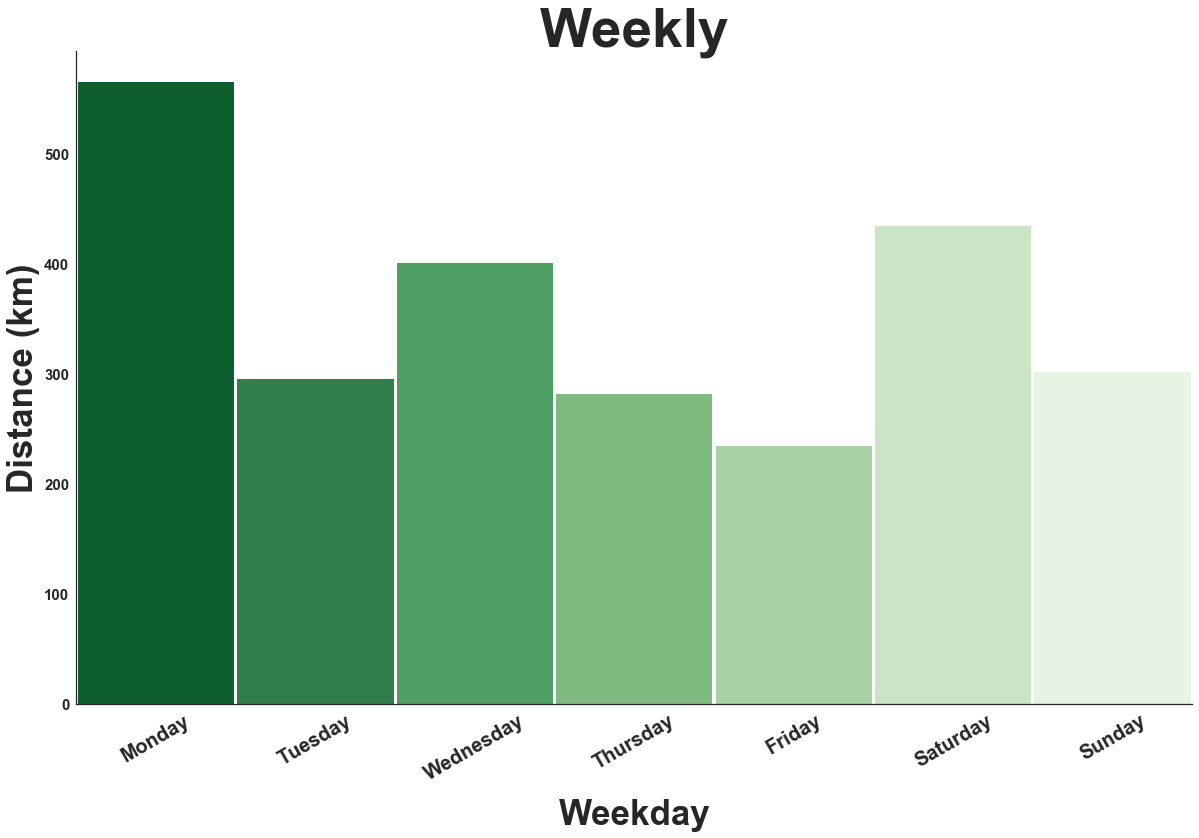

In [10]:
fig, ax, g = plot_bar(df      =  nike_run_sum_week, 
                      feature = 'Distance', 
                      palette = 'Greens_r',
                      #title   = 'Nike+RunClub - Total Running Distance - Weekly \n', 
                      title   = 'Weekly', 
                      ylabel  = 'Distance (km)',
                      xlabel  = 'Weekday',
                      rot = 30)
fig.savefig('FIGS/run_dist_weekly.png',bbox_inches='tight',dpi=dpi)

In [11]:
# run count per week
#pd.DataFrame(nike_run_count_week.loc[:]['Source'])

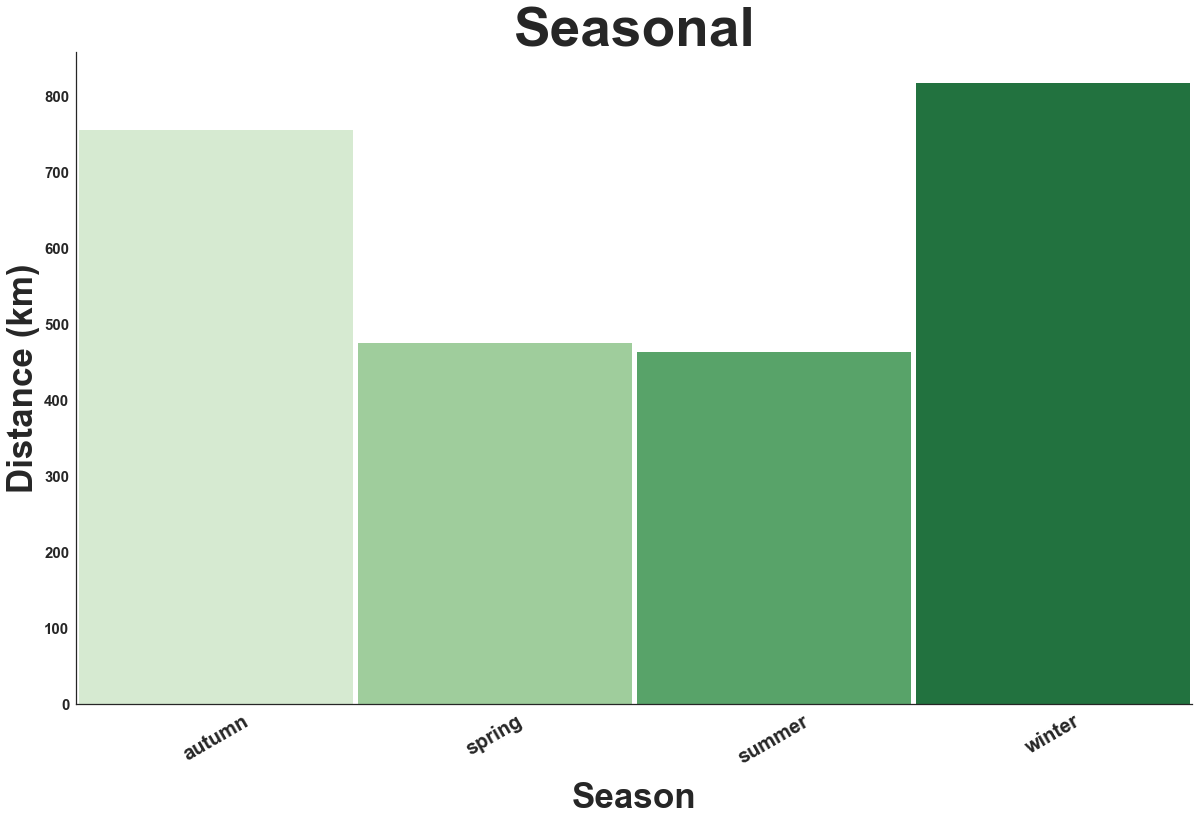

In [12]:
fig, ax, g = plot_bar(df      =  nike_run_sum_season, 
                      feature = 'Distance', 
                      palette = 'Greens',
                      #title   = 'Nike+RunClub - Total Distance throughout - Seasonal\n', 
                      title   = 'Seasonal', 
                      ylabel  = 'Distance (km)',
                      xlabel  = 'Season',
                      rot = 30)
fig.savefig('FIGS/run_dist_season.png',bbox_inches='tight',dpi=dpi)
#print 'Decieving plot ... Data includes N=2 for autumn+winter and N=1 for spring+summer'

# Average Speed

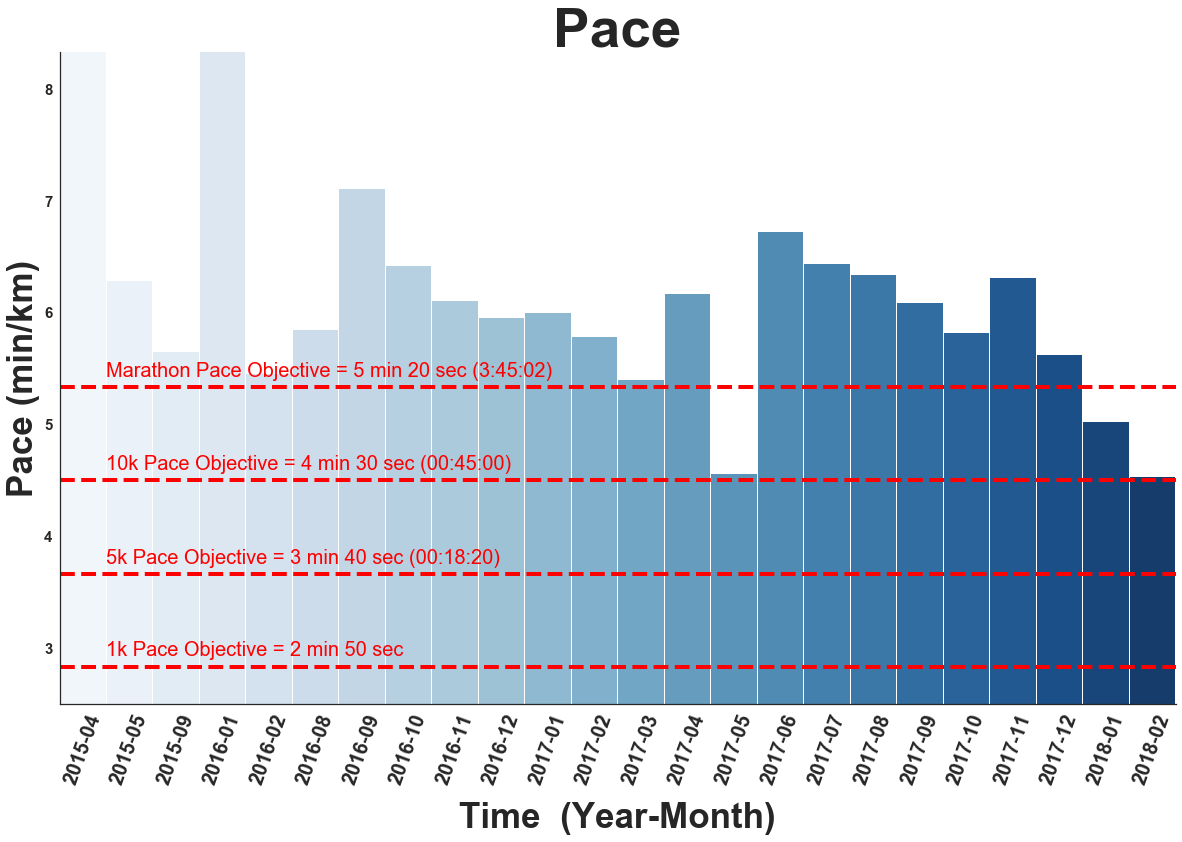

In [13]:
# Average Nike Dataframe by Month 
nike_run_avg_month = df_group_timefeature(nike_run, 'Month', 'mean')
nike_run_avg_month = nike_run_avg_month.drop([i for i in nike_run_avg_month.index if i[0:4] not in years])

# Calculate Tempo
nike_run_avg_month['Tempo'] = 1/ (nike_run_avg_month['Speed'] * (60./1000.))

fig, ax, g = plot_bar(df      =  nike_run_avg_month, feature = 'Tempo', palette = 'Blues',
                      #title   = 'Nike+RunClub - Average Running Pace per month\n', 
                      title   = 'Pace', 
                      ylabel  = 'Pace (min/km)',xlabel  = 'Time  (Year-Month)')

plt.ylim(2.5,8.33)
plt.axhline(2.83,color='r', linewidth=4, linestyle='--')
plt.axhline(3.66,color='r', linewidth=4, linestyle='--')
plt.axhline(4.5,color='r', linewidth=4, linestyle='--')
plt.axhline(5.33,color='r', linewidth=4, linestyle='--')
plt.annotate('1k Pace Objective = 2 min 50 sec', xy=(.5, 2.93), fontsize=20,color='red')
plt.annotate('5k Pace Objective = 3 min 40 sec (00:18:20)', xy=(.5, 3.76), fontsize=20,color='red')
plt.annotate('10k Pace Objective = 4 min 30 sec (00:45:00)', xy=(.5, 4.6), fontsize=20,color='red')
plt.annotate('Marathon Pace Objective = 5 min 20 sec (3:45:02)', xy=(.5, 5.43), fontsize=20,color='red')
fig.savefig('FIGS/run_pace.png',bbox_inches='tight',dpi=dpi)


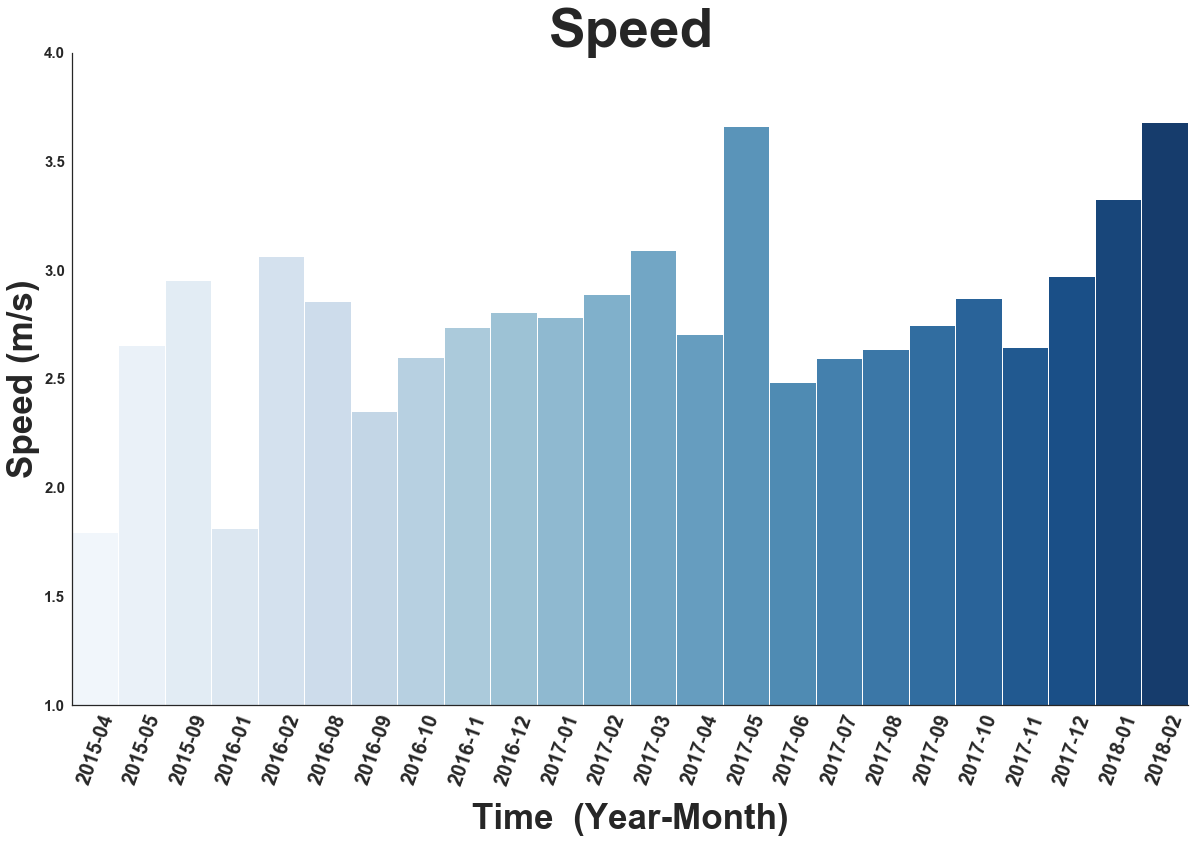

In [14]:
# Average Nike Dataframe by Month 
nike_run_avg_month = df_group_timefeature(nike_run, 'Month', 'mean')
nike_run_avg_month = nike_run_avg_month.drop([i for i in nike_run_avg_month.index if i[0:4] not in years])

# Calculate Tempo
nike_run_avg_month['Tempo'] = 1/ (nike_run_avg_month['Speed'] * (60./1000.))

fig, ax, g = plot_bar(df      =  nike_run_avg_month, feature = 'Speed', palette = 'Blues',
                      #title   = 'Nike+RunClub - Average Running Pace per month\n', 
                      title   = 'Speed', 
                      ylabel  = 'Speed (m/s)',xlabel  = 'Time  (Year-Month)')

plt.ylim(1,4)
fig.savefig('FIGS/run_speed.png',bbox_inches='tight',dpi=dpi)


# Elevation Gain 

Decieving plot..... Device doesnt measure elevetion gain accurately during indoor runs


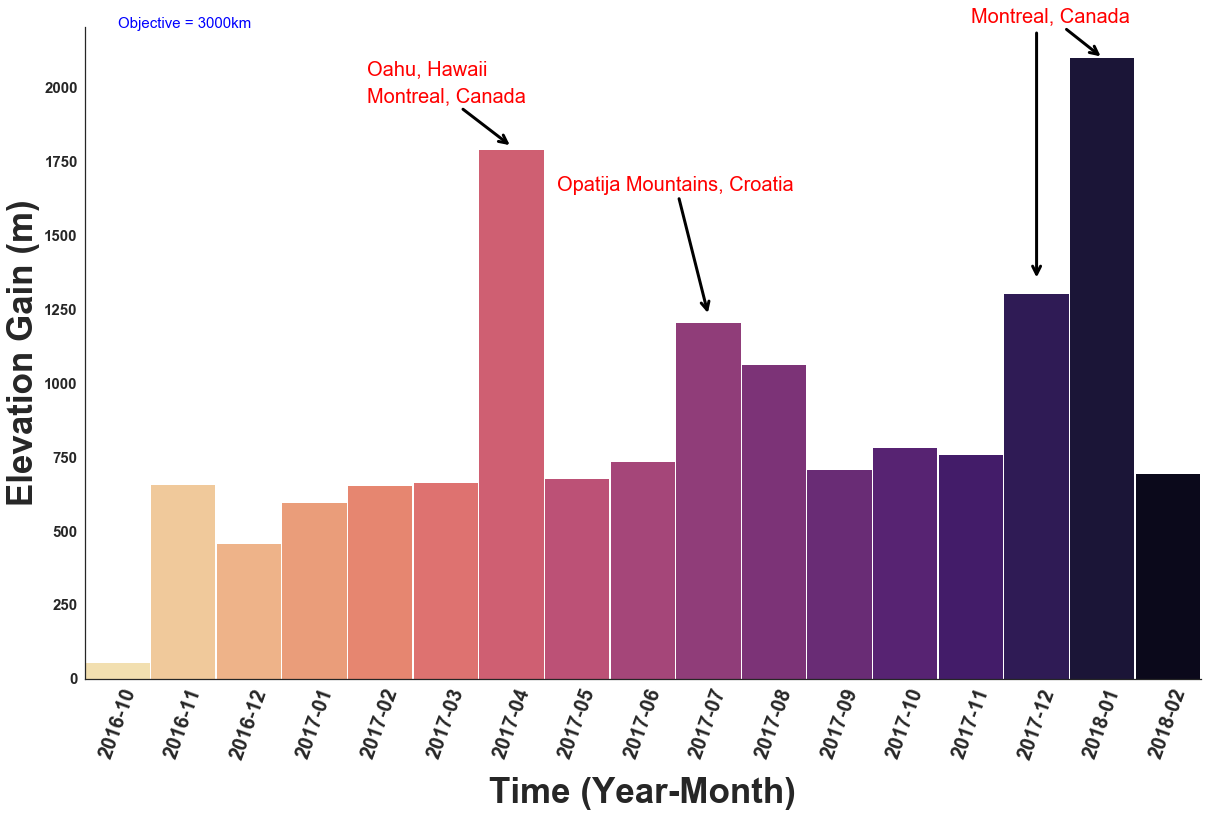

In [15]:
# Sum Elevation Dataframe by Month 
apple_elev_sum_month = df_group_timefeature(apple_elev, 'Month', 'sum')
#Convert Floors to km .... 1 Floors Climb = 3m
apple_elev_sum_month['ElevationGain'] =  apple_elev_sum_month.value*3

fig, ax, g = plot_bar(df      =  apple_elev_sum_month, feature = 'ElevationGain', palette = 'magma_r',
                      title   = '', ylabel  = 'Elevation Gain (m)',xlabel  = 'Time (Year-Month)')
#plt.title('AppleHealthKit - Elevation (km)', fontsize=25, weight='bold')
plt.annotate('Montreal, Canada', xy=(6, 600*3), xytext=(3.8, 650*3),arrowprops=dict(arrowstyle="->", facecolor='red', lw=3), fontsize=20,color='red')
plt.annotate('Oahu, Hawaii', xy=(6, 630*3), xytext=(3.8, 680*3), fontsize=20,color='red')
plt.annotate('Opatija Mountains, Croatia', xy=(9, 410*3), xytext=(6.7, 550*3),arrowprops=dict(arrowstyle="->", facecolor='red', lw=3), fontsize=20,color='red')
plt.annotate('Montreal, Canada', xy=(15, 700*3), xytext=(13, 740*3),arrowprops=dict(arrowstyle="->", facecolor='red', lw=3), fontsize=20,color='red')
plt.annotate('', xy=(14, 450*3), xytext=(14, 730*3), arrowprops=dict(arrowstyle="->", facecolor='red', lw=3), fontsize=20,color='red')
plt.annotate('Objective = 3000km', xy=(.01, 2000), xytext=(.01, 2200), fontsize=15,color='blue')

fig.savefig('FIGS/elevation.png',bbox_inches='tight',dpi=dpi)

print 'Decieving plot..... Device doesnt measure elevetion gain accurately during indoor runs'

# Mass 

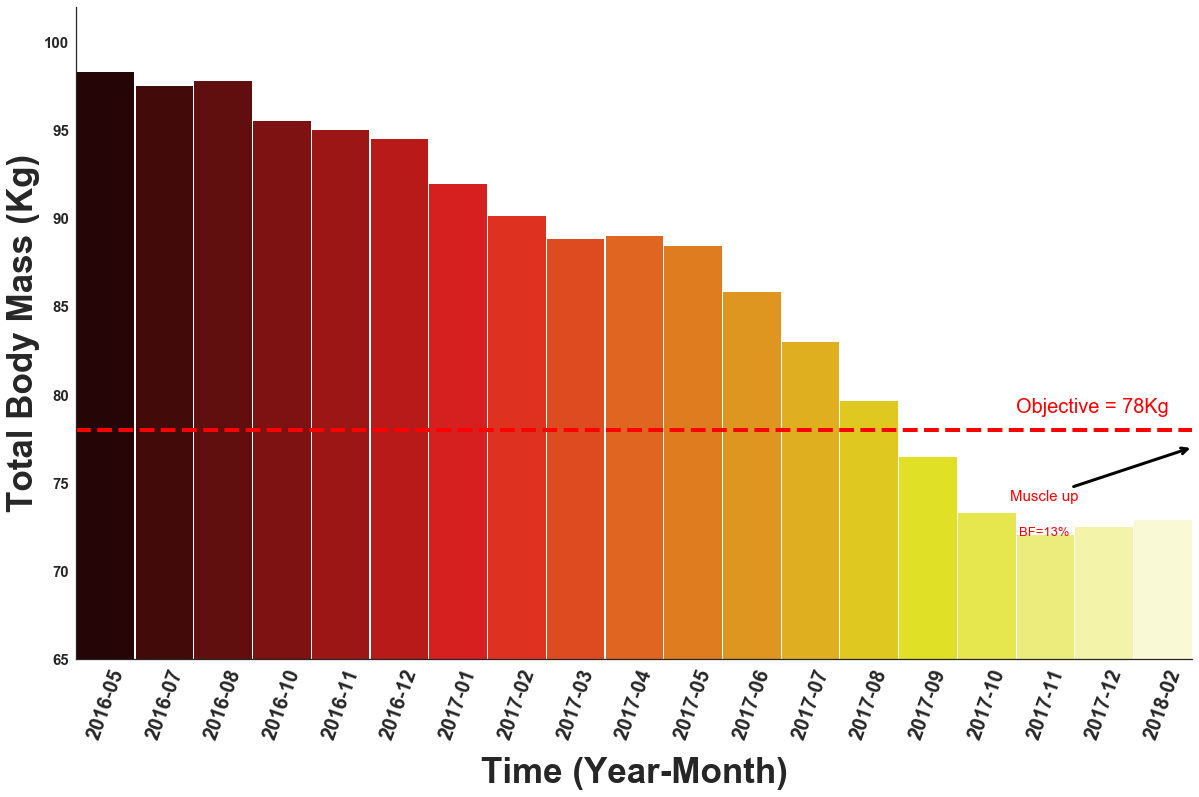

In [16]:
sns.set_style('white')
apple_mass_avg_month = df_group_timefeature(apple_mass, 'Month', 'mean')
fig, ax, g = plot_bar(df      =  apple_mass_avg_month, feature = 'value', palette = 'hot', 
                      #title   = 'Body Mass', 
                      title   = '', 
                      xlabel  = 'Time (Year-Month)', 
                      ylabel  = 'Total Body Mass (Kg)')

plt.ylim(65,102)
plt.axhline(78,color='r', linewidth=4, linestyle='--')
plt.annotate('Objective = 78Kg', xy=(15.5, 79), fontsize=20,color='red')
plt.annotate('Muscle up', xy=(18.5, 77), xytext=(15.4, 74),arrowprops=dict(arrowstyle="->", facecolor='red', lw=3), fontsize=15,color='red')
plt.annotate('BF=13%', xy=(15.55, 72), fontsize=13,color='red')
fig.savefig('FIGS/mass.png',bbox_inches='tight',dpi=dpi, transparent=True)


# Association between running and health features 

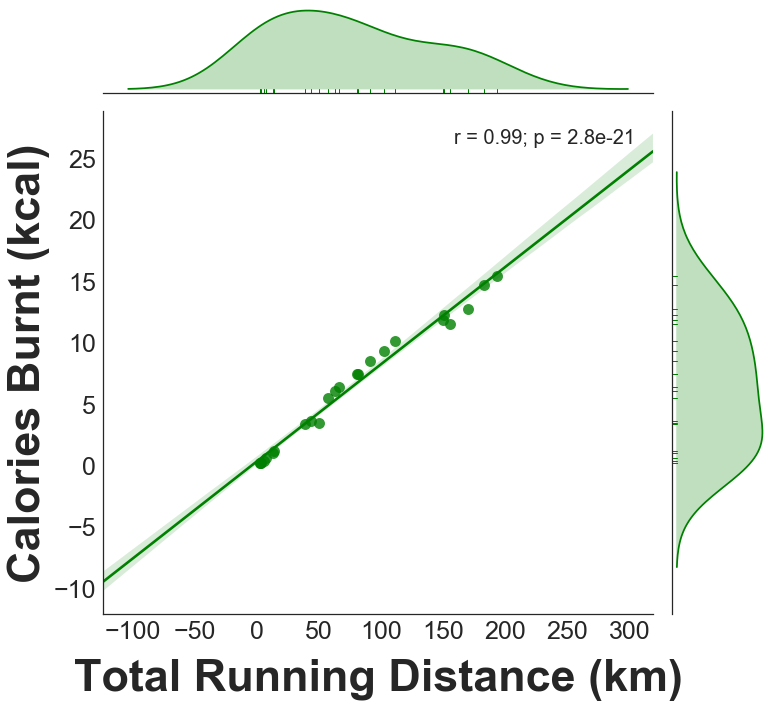

In [17]:
def plt_dist_cal():
    sns.set_style('white')
    matplotlib.rc("legend", fontsize=20)
    g = sns.jointplot(nike_run_sum_month.Distance, nike_run_sum_month.Calories/1000, kind='reg', size=10, color='g',
                      marginal_kws=dict(bins=30, rug=True, hist=False, kde=True, kde_kws={'shade':1}),
                      annot_kws=dict(stat="r"),  scatter_kws={"s": 120})
    #g.fig.suptitle('Distance vs Calories (Monthly)',  fontsize=25, weight='bold')
    g.fig.subplots_adjust(top=.9)
    plt.xlabel('Total Running Distance (km)', fontsize=45, labelpad=15, weight='bold')
    plt.ylabel('Calories Burnt (kcal)', fontsize=45, weight='bold')
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    #plt.xlim(0,250)
    #plt.ylim(0,25)
    plt.savefig('FIGS/corr_dist_cal.png',bbox_inches='tight',dpi=500, transparent=True)

plt_dist_cal()

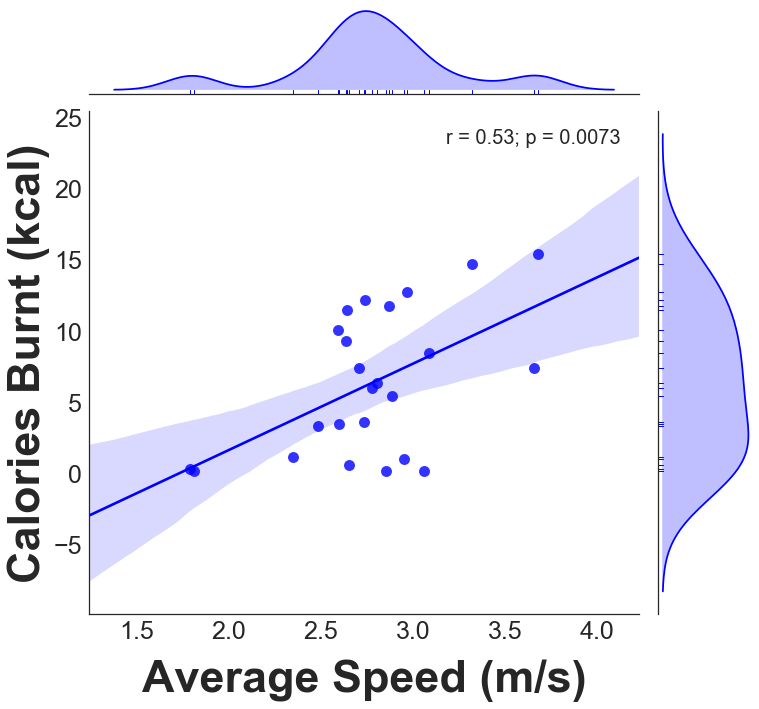

In [18]:

def plt_speed_cal():
    sns.set_style('white')
    matplotlib.rc("legend", fontsize=20)
    g = sns.jointplot( nike_run_avg_month.Speed, nike_run_sum_month.Calories/1000, kind='reg', size=10, color='b',
                      marginal_kws=dict(bins=30, rug=True, hist=False, kde=True, kde_kws={'shade':1}),
                      annot_kws=dict(stat="r"),  scatter_kws={"s": 120})
    #g.fig.suptitle('Speed vs Calories (Monthly)',  fontsize=25, weight='bold')
    g.fig.subplots_adjust(top=.9)
    plt.xlabel('Average Speed (m/s)', fontsize=45, labelpad=15, weight='bold')
    plt.ylabel('Calories Burnt (kcal)', fontsize=45, weight='bold')
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    #plt.xlim(0,250)
    #plt.ylim(0,25)
    plt.savefig('FIGS/corr_speed_cal.png',bbox_inches='tight',dpi=500, transparent=True)
plt_speed_cal()


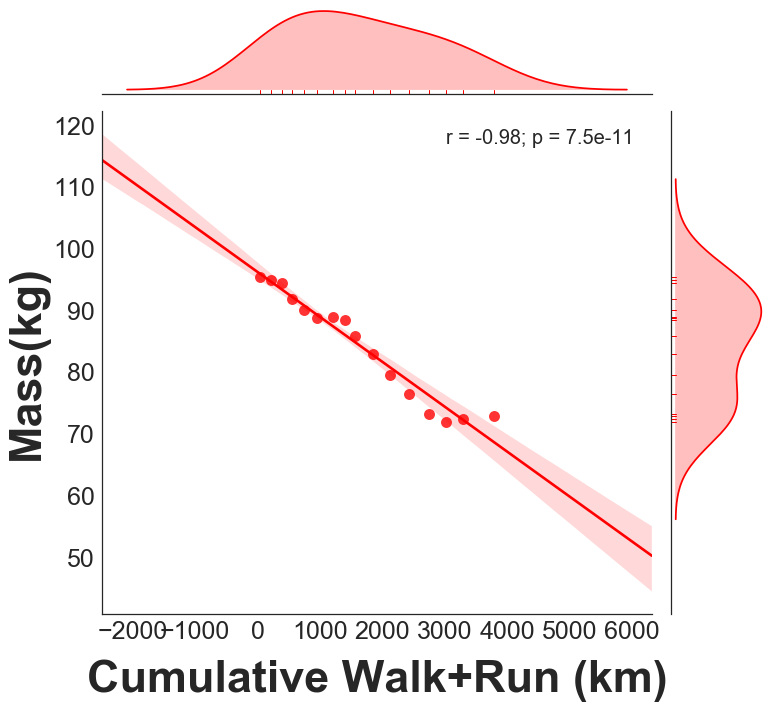

In [19]:
apple_walkrun_month = df_group_timefeature(apple_walkrun, 'Month', 'sum', feature_name='WalkRun')
apple_mass_month    = df_group_timefeature(apple_mass, 'Month', 'mean', feature_name='Mass')

# Concatenate Dataframes
df_walkrun_mass       = pd.concat([apple_walkrun_month, apple_mass_month], axis = 1)#.dropna()

def plt_incremental_WRdist_weight():
    sns.set_style('white')
    matplotlib.rc("legend", fontsize=20)
    g = sns.jointplot(np.cumsum(df_walkrun_mass.WalkRun), df_walkrun_mass.Mass, kind='reg', size=10, color='r',
                      marginal_kws=dict(bins=30, rug=True, hist=False, kde=True, kde_kws={'shade':1}),
                     annot_kws=dict(stat="r"),  scatter_kws={"s": 120})

    #g.fig.suptitle('Incremental WalkRun Distance vs Weight',  fontsize=25, weight='bold')
    g.fig.subplots_adjust(top=.9)
    plt.xlabel('Cumulative Walk+Run (km)', fontsize=45, labelpad=15, weight='bold')
    plt.ylabel('Mass(kg)', fontsize=45, weight='bold')
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    #plt.xlim(0,250)
    #plt.ylim(0,25)
    plt.savefig('FIGS/corr_cumsumwalkrun_mass.png',bbox_inches='tight',dpi=500, transparent=True)

plt_incremental_WRdist_weight()


# Step Count

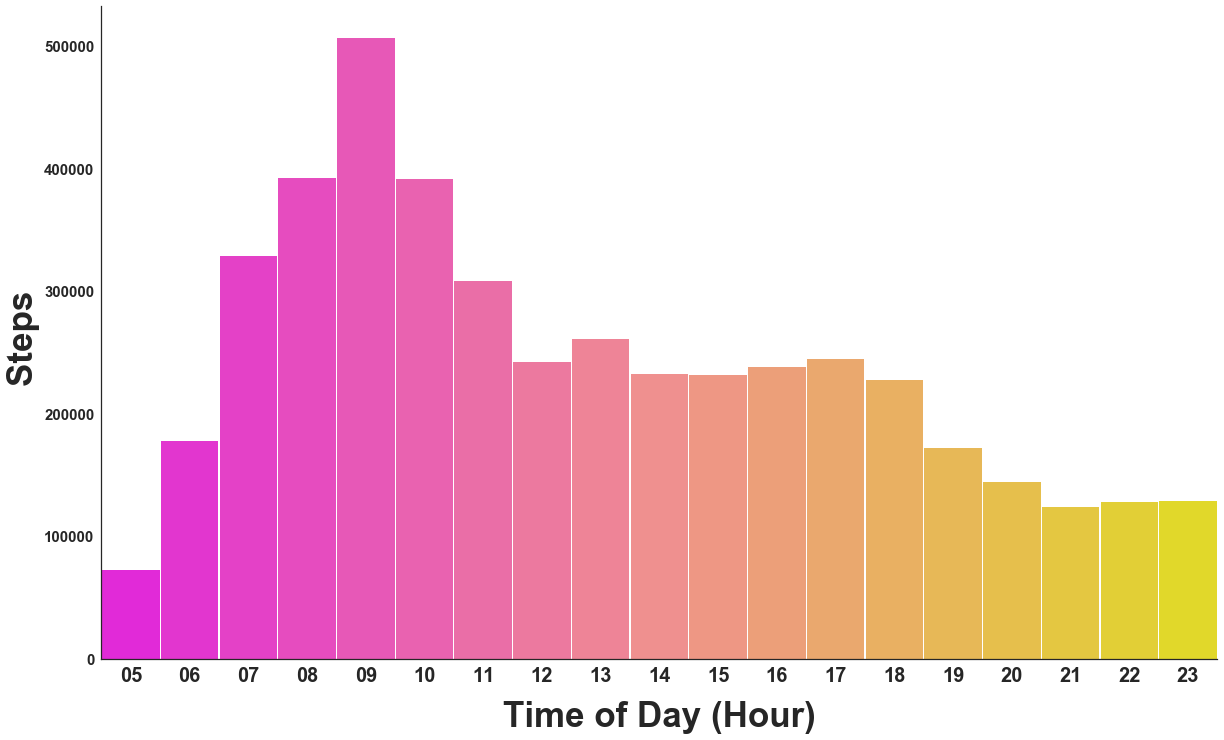

In [20]:
apple_steps_sum_hour = df_group_timefeature(apple_steps, 'Time_of_day_val', 'sum')
fig, ax, g = plot_bar(df      =  apple_steps_sum_hour[5:], 
                      feature = 'value', 
                      palette = 'spring',
                      title   = '', 
                      ylabel  = 'Steps ',
                      xlabel  = 'Time of Day (Hour)',
                      rot = 0)

# Feature Data Clustering  .

- Nike  - Total Running Distance
- Nike  - Average Running Speed
- Apple - Walk+Run Distance
- Apple - Elevation Gain
- Apple - Step Count

# Lets preprocess first 

In [70]:
# Preprocess Features of Interest
### Create two conctenated dataframes. 
#### 1- All Days 
#### 2- Running days only

apple_walkrun_day  = df_group_timefeature(apple_walkrun, 'Day', 'sum', feature_name='WalkRun')
apple_elev_day     = df_group_timefeature(apple_elev, 'Day', 'sum', feature_name='ElevationGain')
apple_steps_day    = df_group_timefeature(apple_steps, 'Day', 'sum', feature_name='StepCount')

nike_run_day_sum   = df_group_timefeature(nike_run, 'Day','sum')
nike_run_day_avg   = df_group_timefeature(nike_run, 'Day','mean')
years = ['2016','2017','2018','2019']
nike_run_day_sum   = nike_run_day_sum.drop([i for i in nike_run_day_sum.index if i[0:4] not in years])
nike_run_day_avg   = nike_run_day_avg.drop([i for i in nike_run_day_avg.index if i[0:4] not in years])

# Concatenate Dataframes
df_features_day       = pd.concat([nike_run_day_sum, apple_walkrun_day, apple_elev_day, apple_steps_day ], axis = 1)#.sort_index()

# Keep features only 
features = ['Distance', 'Speed', 'ElevationGain','WalkRun', 'StepCount']
drop_col = [i for i in df_features_day.columns if i not in features]
df_features_day = df_features_day.drop(drop_col,axis=1)[9:]

# breakdown dataframes into (a) all-days, (b) walk days, (c) run days
df_features_day_all  = df_features_day.fillna(0)

running_days = [i for i in df_features_day_all.index if df_features_day_all.loc[i]['Speed'] != 0.]
walking_days = [i for i in df_features_day_all.index if df_features_day_all.loc[i]['Speed'] == 0.]
df_features_day_run = df_features_day_all.drop(walking_days)
df_features_day_wlk = df_features_day_all.drop(running_days)

# Normalize features by column 
df_features_day_all_z  = normalize_df_bycol(df_features_day_all)
df_features_day_run_z  = normalize_df_bycol(df_features_day_run)

# Samples 

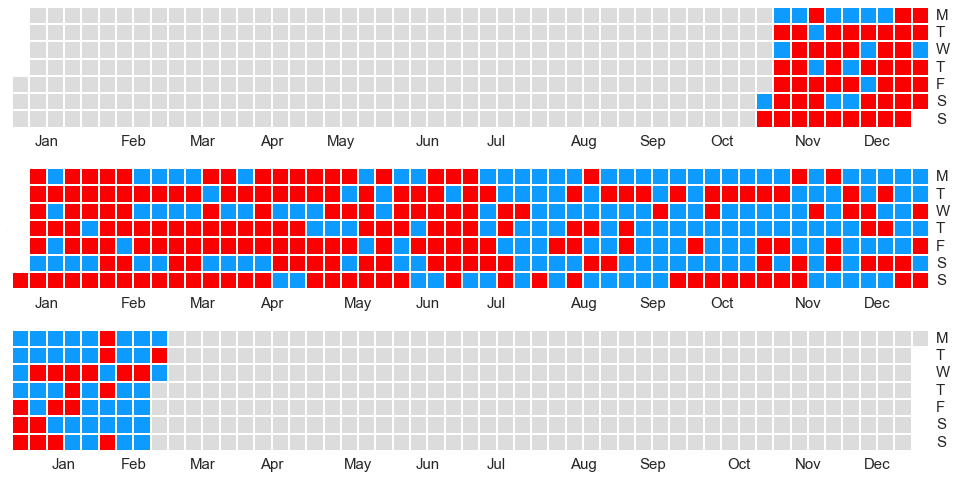

In [81]:
import numpy as np; np.random.seed(sum(map(ord, 'calmap')))
import pandas as pd
import calmap
import datetime
df_cal  = df_features_day_all.copy(deep=True)

for i in df_cal.index:
    if df_cal.loc[i]['Speed'] == 0.:
        df_cal.loc[i, 'cal'] = int(1)
    else:
        df_cal.loc[i,'cal'] = int(2)
        
sns.set(style='white', font_scale=1.5)
cmap_gr = colors.ListedColormap([ '#fb0000', '#0d9bff',])#'#ff0000', 35a94c
cal,axes = calmap.calendarplot(pd.Series(df_cal.cal.values, 
                index=[datetime.datetime.strptime(i,'%Y-%m-%d') for i in df_cal.index]), 
                fillcolor='gainsboro', cmap = cmap_gr, yearascending = 1,
                yearlabel_kws = dict(fontsize=0),  daylabels='MTWTFSS', 
                fig_kws=dict(figsize=(20,7)))

plt.savefig('FIGS/calmap.png',bbox_inches='tight',dpi=400, transparent = True)


# Features 

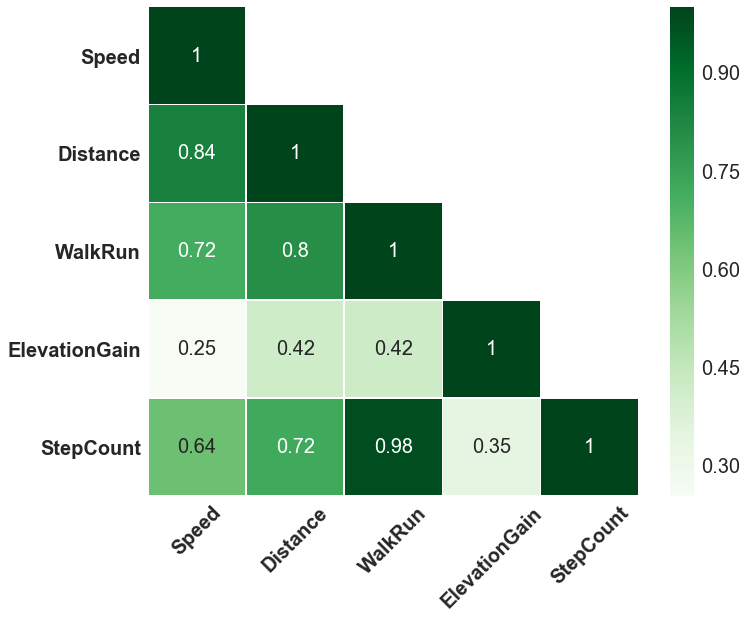

In [52]:
f, ax = plt.subplots(figsize=(11, 9))
corr = df_features_day_all_z.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, k = 1)] = True
sns.set(style='white', font_scale=2)
sns.heatmap(corr, cmap='Greens', linewidths=.5, cbar_kws={"shrink": 1}, 
            ax=ax, annot = True, annot_kws={"size":20}, mask = mask)

plt.xticks(fontsize = 20, weight='bold', rotation=45)
plt.yticks(fontsize = 20, weight='bold', rotation=0)
plt.savefig('FIGS/feature_corr.png',bbox_inches='tight',dpi=500, transparent=True)


# Agglomerative Clustering
## All Days

Total Number of Days= 488


/Users/kanaan/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


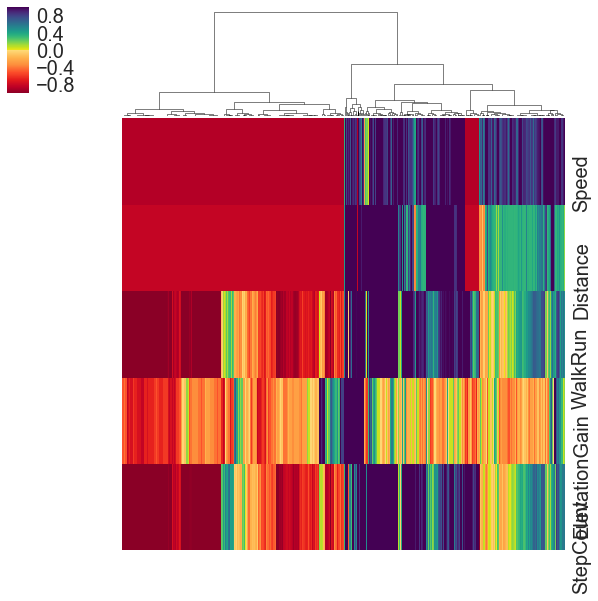

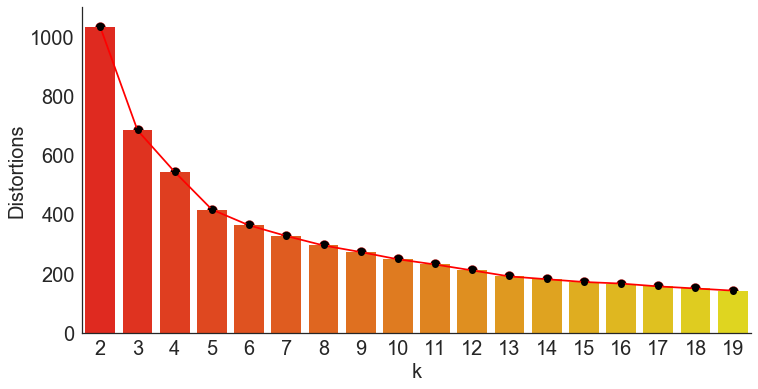

In [53]:
print 'Total Number of Days=', len(df_features_day_all_z) 
sns.set_style('white')
cg = sns.clustermap(df_features_day_all_z.T, xticklabels=False, yticklabels=True, 
                           cmap = cmap_gradient, row_cluster= False, vmin = -1, vmax = 1, 
                            method = 'ward', metric ='euclidean',  )

#plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0, fontsize=20)  # For y axis
#plt.setp(cg.ax_heatmap.get_xticklabels(), rotation=90) # For x axis
cg.savefig('./FIGS/clust_all.png', bbox_inches='tight', transparent=True, dpi=300)

#plot_dendogram(df_features_day_all_z.T, method='ward', metric='euclidean', fname='./FIGS/dend_all.png') 
plot_elbow(df_features_day_all_z, fname='FIGS/elbow_all.png')

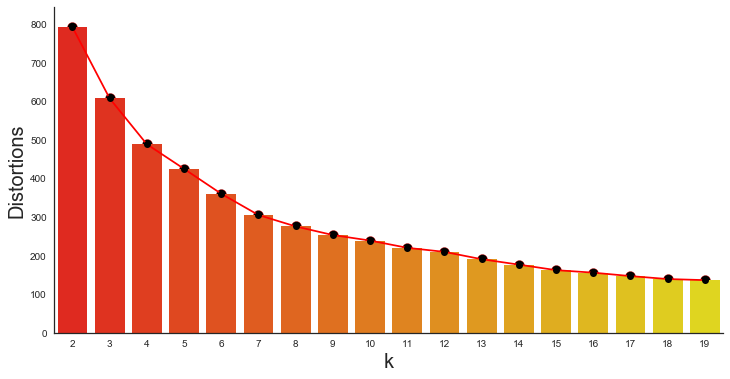

In [69]:
from sklearn.cluster import AgglomerativeClustering, KMeans

def plot_elbow(X, fname=None, title=None):
    distortions = []
    for k in range(2, 20):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    xk = np.array(range(2, 20))
    fig = plt.figure(figsize=(12, 6))
    g = sns.barplot(xk, distortions, palette='autumn')
    # plt.bar(xk, distortions, color='autumn')
    plt.plot(xk - 2, distortions, marker="o", markerfacecolor="k", c='r')
    plt.scatter(xk - 2, distortions, s=100, facecolors='k', edgecolors='r')
    if title:
        plt.title('Optimal Number Of Clusters (Elbow Method)', fontsize=18, weight='bold')
    plt.xlabel('k', fontsize=20)
    plt.ylabel('Distortions', fontsize=20)
    sns.despine(left=False, bottom=False)
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches='tight', transprent=True)

plot_elbow(df_features_day_run_z,fname='./FIGS/elbow_run.png')

Total Number of RUNNING Days= 226


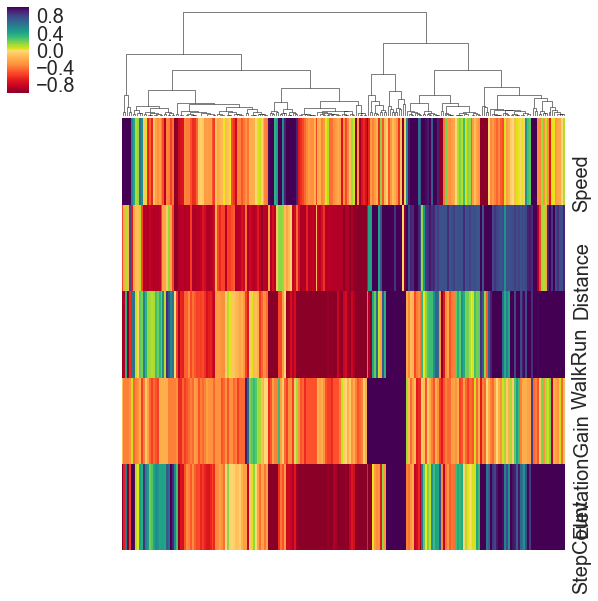

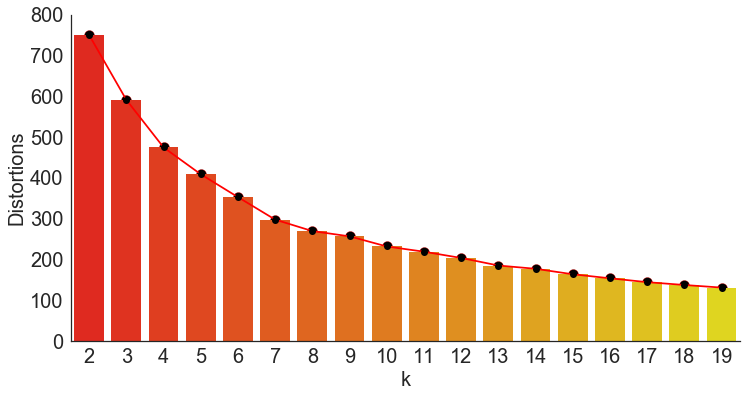

In [54]:
print 'Total Number of RUNNING Days=', len(df_features_day_run_z) 
cg = sns.clustermap(df_features_day_run_z.T, xticklabels=False, 
                    cmap = cmap_gradient, row_cluster= False, vmin = -1, vmax = 1, 
                    method = 'ward', metric ='euclidean',  )
cg.savefig('./FIGS/clust_run.png', bbox_inches='tight', transparent=True, dpi=300)

#plot_dendogram(df_features_day_run_z.T, method='ward', metric='euclidean') 
plot_elbow(df_features_day_run_z,fname='./FIGS/elbow_run.png')

# Inspect cluster structure in low-dimentional embedding space 
- Apply Manifold learning for non-linear dimensionality reduction
- Methods include: isomap, tsne , mds, spectral, lle, kpca, pca

(488, 3)


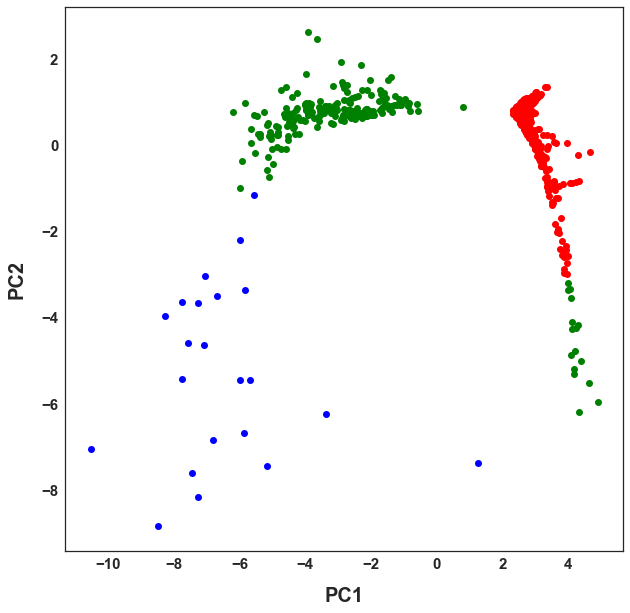

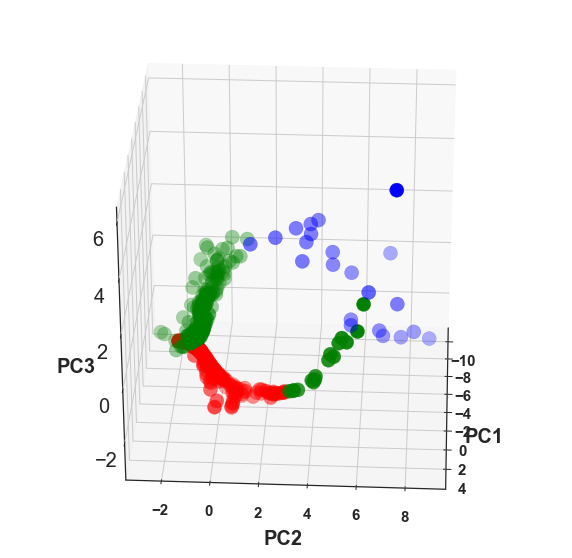

In [55]:
manifold_method = 'isomap'
lle_method='modified'

n_clusters = 3
plot_cluster_components(df_features_day_all_z ,decomposition =  manifold_method, lle_method = lle_method, plot='2D', 
                        #titlex ='Decompsition of feature data into low-dimentional embedding space (ALL-Days)\n',
                        titlex ='', n_clusters=n_clusters,
                        #fname='FIGS/embed_all_2d', 
                       )

plot_cluster_components(df_features_day_all_z ,decomposition =  manifold_method, lle_method = lle_method, plot='3D', 
                        #titlex ='Manifold decompsition of feature data into-low dim embedding space (ALL-Days)\n',
                        titlex ='', n_clusters=n_clusters,
                        azim= 3, elev=30,
                        #fname='FIGS/embed_all_3d'
                       )

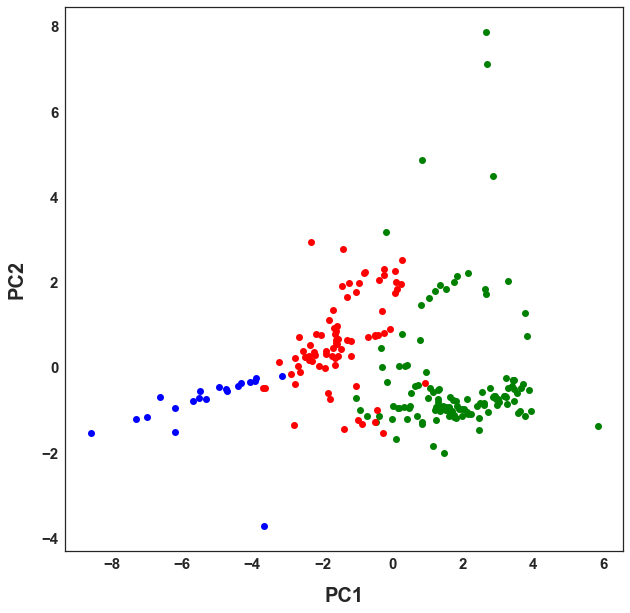

In [79]:
plot_cluster_components(df_features_day_run_z , manifold_method, lle_method, plot='2D', n_clusters=3,
                        #titlex ='Manifold decompsition of feature data into-low dim embedding space (RUN-Days)',
                        titlex='',
                        fname='FIGS/embed_run_2d'
                       )


(226, 3)


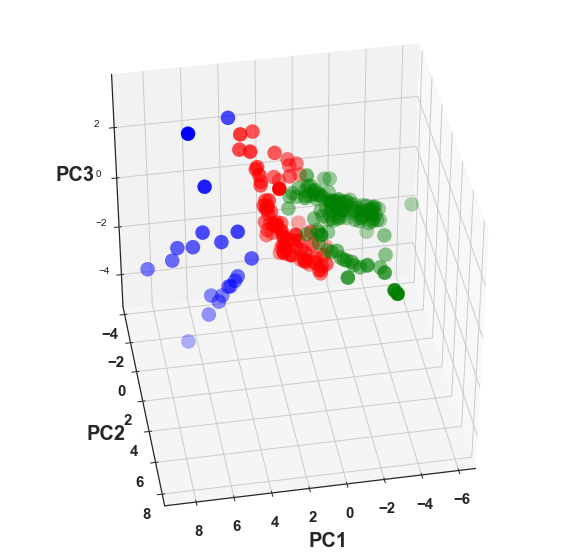

In [75]:

plot_cluster_components(df_features_day_run_z , manifold_method, lle_method, plot='3D', n_clusters=3,
                       #titlex ='Manifold decompsition of feature data into-low dim embedding space (RUN-Days)',
                        titlex='',
                        azim= 80, elev=40,
                        fname='FIGS/embed_run_3d'
                       )

# Feature differences for the different day clusters 

In [82]:
n_clusters  = 3
features = ['Distance', 'Speed', 'ElevationGain','WalkRun', 'StepCount']

# #####################################################################'
## ALL-DAYS ----- Clustering indicates data broken down into groups with: 
    - (a) Very Active days 
    - (b) Normal Active days 
    - (c) Sedentary days

((array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text xticklabel objects>),
 (array([0.5, 1.5, 2.5]), <a list of 3 Text yticklabel objects>))

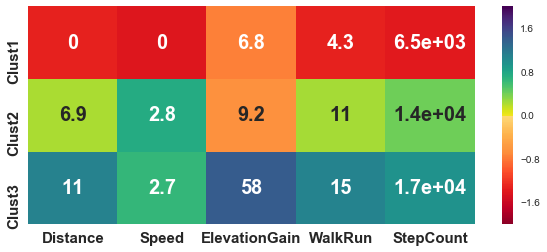

In [90]:
sns.set(style='white', font_scale=1)
clust_all, clust_allL,clust_allZ = return_cluster_dfs(df_features_day_all, df_features_day_all_z, n_clusters, features)
clust_all =clust_all.reindex(index=['cluster_2','cluster_1','cluster_3'])
f, ax = plt.subplots(figsize=(10,4))
sns.heatmap(normalize_df_bycol(clust_all), annot=clust_all, cmap=cmap_gradient,  
            annot_kws={"size":20, 'weight':'bold'},yticklabels=(['Clust1','Clust2','Clust3']),
            vmin=-2,vmax=.5)
plt.xticks(fontsize = 15, weight='bold',rotation=0), plt.yticks(fontsize = 15, weight='bold')
#plt.savefig('./FIGS/cluster_df_means_all.png',bbox_inches='tight',dpi=300, transparent=True)

# #####################################################################'
### Indicates that RUNNING days are broken down into 
    - (a) Recovery Runs  ----- Short Distance (5Km), Low ElevationGain, 5.3 min pace
    - (b) Distance Runs  ----- Medium Distance (10Km+), Low Elevation,  5.3 min pace
    - (c) Mountain Runs with speed ----- Medium Distance (10Km+), High-elevation, 6.2min pace

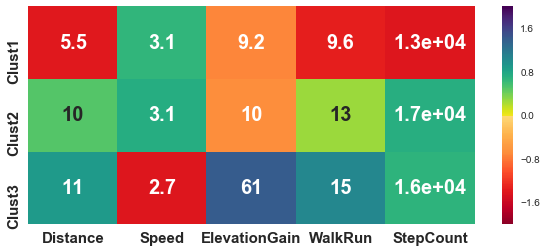

In [91]:
n_clusters  = 3
clust_run ,clust_runL,clust_runZ = return_cluster_dfs(df_features_day_run, df_features_day_run_z, n_clusters, features)

f, ax = plt.subplots(figsize=(10,4))
sns.heatmap(normalize_df_bycol(clust_run), annot=clust_run, cmap=cmap_gradient,  
            annot_kws={"size":20, 'weight':'bold'}, yticklabels=(['Clust1','Clust2','Clust3']),
            vmin=-2,vmax=.5)
plt.xticks(fontsize = 15, weight='bold',rotation=0), plt.yticks(fontsize = 15, weight='bold')

plt.savefig('./FIGS/cluster_df_means_run.png',bbox_inches='tight',dpi=300, transparent=True)


In [85]:
normalize_df_bycol(clust_run)

,Distance,Speed,ElevationGain,WalkRun,StepCount
cluster_1,-1.396479,0.666467,-0.726997,-1.340498,-1.413901
cluster_2,0.504886,0.746983,-0.687028,0.279995,0.732717
cluster_3,0.891592,-1.413449,1.414025,1.060503,0.681184


# Day count per Cluster

In [86]:
clust_runL.groupby('label').count()


,Speed,Distance,WalkRun,ElevationGain,StepCount
label,,,,,
0,125,125,125,125,125
1,81,81,81,81,81
2,20,20,20,20,20


In [87]:
clust_allL.groupby('label').count()



,Speed,Distance,WalkRun,ElevationGain,StepCount
label,,,,,
0,221,221,221,221,221
1,245,245,245,245,245
2,22,22,22,22,22


In [88]:
# Total number of Days 
np.sum(clust_allL.groupby('label').count()['Distance'])

488

In [64]:
# Total number of running days
np.sum(clust_runL.groupby('label').count()['Distance'])

226

In [104]:
population = nike_run_sum_month.Distance[6:]

In [105]:
for pop in range(1, len(population)):
    gnumbers = ((population[pop] - population[pop-1]) * 100.0 / population[pop-1])

In [106]:
gnumbers 

5.352172908565069

In [134]:
50.036725 * 0.72

36.026441999999996

In [133]:
DFX.Distance

0      13.934160
1      50.036725
2      43.108390
3      65.886930
4      62.757780
5      56.672715
6      90.744380
7      81.032519
8      80.493580
9      38.209220
10    111.419511
11    102.346160
12    150.280920
13    149.685150
14    155.206100
15    169.826070
16    183.093300
17    192.892770
Name: Distance, dtype: float64

In [166]:
# average increase of mothly distance over last 18 months 
growth = []
DFX = nike_run_sum_month[6:].reset_index()
for i in DFX.index:
    if i in range(17):
        g = DFX.loc[i+1]['Distance'] - DFX.loc[i]['Distance'] 
        growth.append(g)
        
print growth
print np.sum(growth) / len(DFX)

[36.102564722371305, -6.928334722371183, 22.77853999999909, -3.129149999997935, -6.085064932987152, 34.071664932988114, -9.711860526456874, -0.5389394735450992, -42.28435999999932, 73.21029117094008, -9.073351170941834, 47.934759999993844, -0.5957699999942747, 5.52094999999855, 14.619969807453828, 13.26723019254834, 9.79946999999774]
9.942144999999847


In [187]:
# average increase of mothly distance over last 18 months 
growth = []
DFX = nike_run_avg_month[6:].reset_index()
for i in DFX.index:
    if i in range(17):
        g = DFX.loc[i+1]['Tempo'] - DFX.loc[i]['Tempo'] 
        growth.append(g)
        
print growth
print np.sum(growth) / len(DFX)

[-0.6817986857072214, -0.3172190648567792, -0.15146595965487908, 0.04907265625375867, -0.21916101892304507, -0.3801062160374311, 0.7671030282042688, -1.6084861806011101, 2.1591525553877498, -0.2878203171817528, -0.0994869436619048, -0.24780736639513457, -0.26860381774577835, 0.49579855794814254, -0.6921836234643104, -0.5969701710909501, -0.48765641394915704]
-0.14264661008197413


In [181]:
0.8117925826404588 * 60


48.70755495842753

In [195]:
np.mean(nike_run_avg_month[10:].Tempo)

5.7668421261905305

In [201]:
np.mean(apple_elev_sum_month[10:].value)

352.2857142857143

In [185]:
0.3494054922757553 * 60

20.964329536545318

In [196]:
.7668421261905305 * 60

46.01052757143183

In [203]:
nike_run_avg_month.Tempo

Month
2015-04    9.317017
2015-05    6.283321
2015-09    5.646509
2016-01    9.210355
2016-02    5.447965
2016-08    5.843091
2016-09    7.098861
2016-10    6.417062
2016-11    6.099843
2016-12    5.948377
2017-01    5.997450
2017-02    5.778289
2017-03    5.398183
2017-04    6.165286
2017-05    4.556800
2017-06    6.715952
2017-07    6.428132
2017-08    6.328645
2017-09    6.080838
2017-10    5.812234
2017-11    6.308032
2017-12    5.615849
2018-01    5.018879
2018-02    4.531222
Name: Tempo, dtype: float64